### Variational Autoencoder - Convolution Net. 

In [0]:
import os
import random
import copy
import pickle
import joblib
from  PIL import Image
  
import numpy as np
from scipy.stats import norm
import torch
import torch.nn.functional as F
from torch import nn
import torchvision as tv
from skimage import io, transform
from sklearn.cluster import KMeans

from torch.utils import data
from skimage import io
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [0]:
use_cuda = torch.cuda.is_available()

def make_device(use_gpu=True):
    """ Return device.
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu") \
           if use_gpu \
           else torch.device("cpu")
  
device = make_device(True)

### Download collection of images from a github.

In [0]:

#!git clone https://github.com/kotliarov/Dataset2.git
#!cat Dataset2/images.tar.gz.parta* > master.tar.gz
#!tar -xzf master.tar.gz



In [70]:
!ls -al images



total 4132
drwxr-xr-x 3 root root    4096 Oct 18 14:37 .
drwxr-xr-x 1 root root    4096 Oct 18 14:37 ..
drwxr-xr-x 2 1000 1000 4222976 Oct 17 18:10 thumb70


### Define dataset class to provide access to image collections.

In [0]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data_root, list_ids, labels):
        'Initialization'
        self.labels = labels
        self.list_ids = list_ids
        self.data_root = data_root

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_ids)

  def __getitem__(self, index):
        """Generates one sample of data"""
        ID = self.list_ids[index]
        X = tensor_from_image(os.path.join(self.data_root, "{}.png".format(ID)))
        return X, ID


def tensor_from_image(path):
    """
    Return tensor that represents specified image.
    """
    image = Image.open(path).convert('L')

    im_size = 100

    # Resize image, keeping aspect ratio, such that 
    # smaller side of the image is set to 100 px.

    width, height = image.size
    if width > height:
        ratio = width / height
        new_w, new_h = (int(0.5 + im_size * ratio), im_size)
    else:
        ratio = height / width
        new_w, new_h = (im_size, int(0.5 + im_size * ratio))
    image = image.resize((new_w, new_h))
    width, height = image.size

    # Crop center of the image
    crop_width, crop_height = (im_size, im_size)
    dx = (width - crop_width) // 2
    dy = (height - crop_height) // 2
    left, right = dx, dx + crop_width
    top, bottom = dy, dy + crop_height
    image = image.crop((left, top, right, bottom))

    np_image = np.array(image, dtype=np.float32)
    np_image = np.reshape(np_image, (im_size, im_size, 1))
    np_image /= 255.
    #np_image -= 0.5
    #np_image /= 
    np_image = np_image.transpose((2, 0, 1))

    X = torch.from_numpy(np_image).type(torch.FloatTensor)
    return X
                                      
def get_image_mean():
    """ Return collection of mean values for color channels
        of ImageNet images.
    """
    return [0.485, 0.456, 0.406]

def get_image_std():
    """ Return collection of deviation values for color channels
        of ImageNet images.
    """
    return [0.229, 0.224, 0.225]

In [0]:
IM_WIDTH = 100
IM_HEIGHT = 100

### Define function that returns data loaders for train, validation and test image sets.

In [0]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])
#transform = tv.transforms.Compose([tv.transforms.ToTensor(),
#                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



def make_openi_loaders():

  def make_data_set(name):
    X = []
    with open("images/thumb70/ID_{}.txt".format(name), "r") as src:
      for line in src:
        line = line.strip()
        if line:
          X.append(line)
    Y = {}
    with open('images/thumb70/Label_{}.txt'.format(name), "r") as src:
      for line in src:
        line = line.strip()
        if line:
          image_id, label = (line, "1")
          Y[image_id] = label
    return X, Y
  
  
  X_train, y_train = make_data_set("train")
  X_test, y_test = make_data_set("test")
  X_valid, y_valid = make_data_set("valid")
  
  print("Train={} Valid={} Test={}".format(len(X_train), len(X_valid), len(X_test)))
  datasets = {
        'train': Dataset("images/thumb70", X_train, y_train),
        'test':  Dataset("images/thumb70", X_test, y_test),
        'valid': Dataset("images/thumb70", X_valid, y_valid)
  }
  dataloaders = {
        name: torch.utils.data.DataLoader(value, batch_size=64, shuffle=True) for name, value in datasets.items()
  } 
  return dataloaders

In [75]:
dataloader_openi = make_openi_loaders()

Train=62576 Valid=5168 Test=4681


### Helper function to render an image represented as a tensor (pytorch data structure)

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.5, .5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

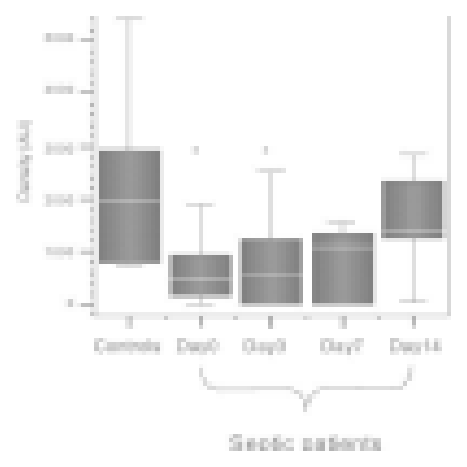

In [80]:
#image, label = next(iter(dataloader_openi['train']))
#print("Shape={}".format(image.shape))
#imshow(image[0])
#image.shape

imshow(tensor_from_image('images/thumb70/PMC1074707_ijmsv01p0126g01.png'))

### Define checkpoint data store that provides ability to persist a NN model to a file as well as load NN model from a file.

In [0]:
class CheckpointStore(object):
    def __init__(self, path):
        self.root = path
    
    def save(self, filename, model):
        """ Save model and its metadata.
            For `densenet` models saving/loading state dictionary 
            does not work: we will not get same model back.
            Solution is to save complete model.
        """
        checkpoint = {
            'model': copy.deepcopy(model),
        }
        path = os.path.join(self.root, filename)
        torch.save(checkpoint, path)
        return path

    @staticmethod
    def read(filepath):
        """ Return checkpoint dictionary.
        """
	    # Read checkpoint file and re-map storage
        # to lowest common denominator - 'cpu'.
        return torch.load(filepath, map_location=lambda storage, loc: storage)
    
    @staticmethod
    def loadModel(filepath):
        cp = CheckpointStore.read(filepath)
        model = cp['model']
        model.to(make_device())
        return model

### Define model for training Variational Auto Encoder.

In [0]:
class Model(torch.nn.Module):
    def __init__(self, depth, code_size):
        super(Model, self).__init__()
        self.depth = depth
        self.code_size = code_size
        
        self.conv1 = nn.Conv2d(depth, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        
        # Latent vectors
        self.fc1 = nn.Linear(25*25*16, self.code_size) #2048
        self.fc_bn1 = nn.BatchNorm1d(self.code_size)
        self.fc21 = nn.Linear(self.code_size, self.code_size)
        self.fc22 = nn.Linear(self.code_size, self.code_size)
        
        # Sampling vector
        self.fc3 = nn.Linear(self.code_size, self.code_size)
        self.fc_bn3 = nn.BatchNorm1d(self.code_size)
        self.fc4 = nn.Linear(self.code_size, 25*25*16)
        self.fc_bn4 = nn.BatchNorm1d(25*25*16)
        
        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, depth, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()
        
        #self.encoder_fc1 = torch.nn.Linear(input_size, hidden_size)
        #self.fc_mu = torch.nn.Linear(hidden_size, code_size)
        #self.fc_logvar = torch.nn.Linear(hidden_size, code_size)
        
        #self.decoder_fc1 = torch.nn.Linear(code_size, hidden_size)
        #self.decoder_fc2 = torch.nn.Linear(hidden_size, input_size)

    def fit(self, dataloader, device, num_epochs, learn_rate):
        """
        """    
        optimizer  = torch.optim.Adam(self.parameters(), lr=learn_rate)

        best_loss = 10000
        checkpoint = CheckpointStore("checkpoints.{}".format(self.code_size))
        
        train_loss = []
        test_loss = []
        for epoch in range(num_epochs):
            acc = []
            for x, _ in iter(dataloader('train')):
                self.train()
                x = x.to(device)
                optimizer.zero_grad()
                x_hat, mu, logvar = self.forward(x)
                loss = Model.vae_loss(x_hat, x, mu, logvar)
                acc.append(loss.item())
                loss.backward()
                optimizer.step()
            train_loss.append(np.mean(acc))
            loss = self.validate(dataloader('valid'), device)
            if loss < best_loss:
              checkpoint.save("best_model.pt", self)
            test_loss.append(loss)
            print("Epoch={} Loss={}".format(epoch, loss))
            checkpoint.save("model_{}.pt".format(len(test_loss)), self)
        return train_loss, test_loss
    
    def validate(self, dataloader, device):
        self.eval()
        with torch.no_grad():
            acc = []
            for x, _ in iter(dataloader):
                x = x.to(device)
                x_hat, mu, logvar = self.forward(x)
                loss = Model.vae_loss(x_hat, x, mu, logvar)
                acc.append(loss.item())
            return np.mean(acc)
        
    def encode(self, x):
        """ VAE encoder step.
            Return vectors mu and log_variance for
            distribution Q(z|x) that approximates P(z|x).
        """
        #h = F.relu(self.encoder_fc1(x))
        #return self.fc_mu(h), self.fc_logvar(h)
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 25*25*16)
        # Latent vectors
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        mu = self.fc21(fc1)
        std = self.fc22(fc1)
        return mu, std
                          
        
    def decode(self, z):
        """ VAE decoder step.
            Return reconstructed vector x_hat.
        """
        #h = F.relu(self.decoder_fc1(z))
        #return torch.sigmoid(self.decoder_fc2(h))

        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)
        #print(fc4.shape)
        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        #print(conv5.shape)
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        #print(conv6.shape)
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        #print(conv7.shape)
        out = self.conv8(conv7).view(-1, self.depth, 100, 100)
        return torch.sigmoid(out)
        
        
    def reparam(self, mu, logvar):
        """ Return vector representing latent state `z`.
            Sample `z` - latent vector - from 
            distribution Q(z|x).
        """
        if self.training:
            sigma = torch.exp(0.5*logvar)
            e = torch.randn_like(sigma)
            return e.mul(sigma).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        """ Forward step VAE encoder / decoder.
        """
        mu, logvar = self.encode(x) #.encode(x.view(-1, self.input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def infer(self, x):
        """ Return z - latent state sampled from Q(z|x)
        """
        self.eval()
        with torch.no_grad():
            mu, logvar = self.encode(x) #self.encode(x.view(-1, self.input_size))
            return self.reparam(mu, logvar)
        
    @staticmethod
    def vae_loss(x_hat, x, mu, log_variance):
        """ Return value of lower bound of data log likelihood:
                sum of reconstruction error and divergence between
                Q(z|x) and P(z|x).
        """
        batch_size, c, w, h = x_hat.shape
        bce = F.binary_cross_entropy(x_hat, x) #x.view(-1, x_size))
        
        divergence = -0.5 * torch.sum(1. + log_variance - mu.pow(2) - log_variance.exp())
        divergence /= (batch_size * c * w * h)
        return bce + divergence
    
    @staticmethod
    def loss_mse(x_hat, x):
        return nn.MSELoss(reduction="sum")(x_hat, x)


### Train VAE model.

In [0]:
N = 100*100
model = Model(1, 256)
device = make_device(True)
model.to(device)
err_train, err_valid = model.fit(lambda name: dataloader_openi[name], device, 30, 0.001)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch=0 Loss=0.3026753079008173
Epoch=1 Loss=0.2952589786347048
Epoch=2 Loss=0.2894553538457847
Epoch=3 Loss=0.2877518985374474
Epoch=4 Loss=0.2832842281571141
Epoch=5 Loss=0.28117502232392627
Epoch=6 Loss=0.2792501109249798
Epoch=7 Loss=0.2782813141375412
Epoch=8 Loss=0.2778903359984174
Epoch=9 Loss=0.27598644774637104
Epoch=10 Loss=0.27727733901989315
Epoch=11 Loss=0.2751149422960517
Epoch=12 Loss=0.27413841364560304
Epoch=13 Loss=0.27393563367702345
Epoch=14 Loss=0.27561353404580813
Epoch=15 Loss=0.27283761162816744
Epoch=16 Loss=0.2739616161511268
Epoch=17 Loss=0.2725956009493934
Epoch=18 Loss=0.27371427048871544
Epoch=19 Loss=0.2715231866380315
Epoch=20 Loss=0.2718190795477526
Epoch=21 Loss=0.27183252499427324
Epoch=22 Loss=0.2713497812733238
Epoch=23 Loss=0.27086084841946023
Epoch=24 Loss=0.27057160197952645
Epoch=25 Loss=0.2709659864137202
Epoch=26 Loss=0.2709106644730509
Epoch=27 Loss=0.2701747570140862
Epoch=28 Loss=0.27133178618955023
Epoch=29 Loss=0.2705045360841869


### Sanity check: read batch of test images and check output of the VAE model: store it in file. 

In [0]:
#model = CheckpointStore.loadModel("checkpoints/model_1.pt")

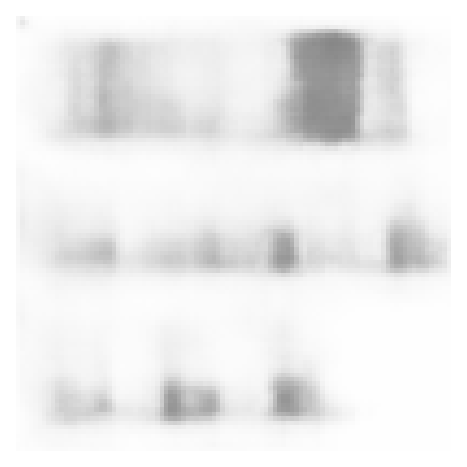

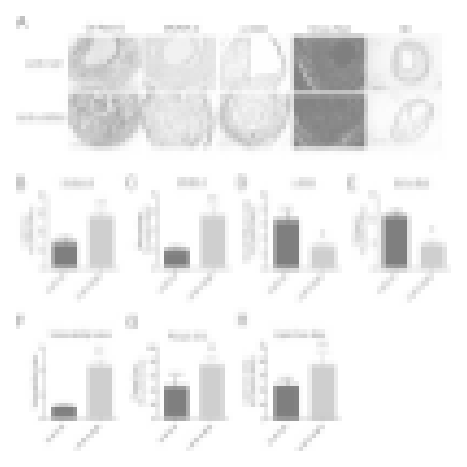

In [0]:
depth = 1
model.eval()
with torch.no_grad():
    device = make_device(True)
    for x, y in iter(dataloader_openi['test']):
        x = x.to(device)
        x_hat, _, _ = model.forward(x)
        im = x_hat.cpu().detach().numpy()
        im.resize(x_hat.shape[0], depth, IM_WIDTH, IM_HEIGHT)
        imshow(torch.Tensor(im[0]))
        im = x.cpu().detach().numpy()
        im.resize(x_hat.shape[0], depth, IM_WIDTH, IM_HEIGHT)
        imshow(torch.Tensor(im[0]))
                 
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
        n = min(x.size(0), 8)
        comparison = torch.cat([x[:n],
                                  x_hat.view(x.shape[0], depth, IM_WIDTH, IM_HEIGHT)[:n]])
        tv.utils.save_image(comparison.data.cpu(),
                          'reconstruction_' + str(1) + '.png', nrow=n)

        break

In [0]:
files.download('reconstruction_1.png')

### Use VAE projection of an image to a latent space to cluster images.

In [0]:
def make_kmeans_model(X, num_clusters):
  """
  Fit KMeans clustering model to specified data set.
  Return tuple (model, score)
  """
  model = KMeans(n_clusters=num_clusters)
  model.fit(X)
  return model, model.score(X)

In [0]:
def image2LatentSpace(dataloader, encoder):
  device = make_device(True)
  X = []
  Y = []
  for x, y in iter(dataloader):
      x = x.to(device)
      mu = encoder.infer(x)
      mu = mu.cpu().detach().numpy()
      X.extend(mu)
      Y.extend(y)
  return np.array(X), Y 

In [0]:
def select_kmeans_model(X, cluster_size):
  """
  """
  best_score = None
  best_model = None
  best_c = 0
  for c in cluster_size:
    model, score = make_kmeans_model(X, c)
    score = abs(score)
    if best_score is None or best_score > score:
      best_score = score
      best_model = model
      best_c = c
    print("Cluster size={} score={}".format(c, score))
  return best_c, best_model

### Fit KMeans model with images mapped to 256-d latent space.
    - Use train data set to fit the model
    - Select cluster size based on "elbow" method
    - Predict cluster assignments for test and train data
    - Persist KMeans model
    - Persist clusters' assignments.

In [0]:
encoder = CheckpointStore.loadModel("checkpoints.256/best_model.pt")
mu_train_256, y = image2LatentSpace(dataloader_openi['train'], encoder)
num_clusters, knn_model = select_kmeans_model(mu_train_256, [4, 6, 8, 10, 12])

Cluster size=4 score=4305603.5
Cluster size=6 score=4237316.0
Cluster size=8 score=4184028.5
Cluster size=10 score=4146545.25
Cluster size=12 score=4113301.25


In [0]:
num_clusters, knn_model = select_knn_model(mu_train_256, [8])

Cluster size=8 score=4184026.5


In [0]:
joblib.dump(knn_model, 'checkpoints.256/knn_model.8.pt')

['checkpoints.256/knn_model.8.pt']

In [0]:
mu, y = image2LatentSpace(dataloader_openi['test'], encoder)
clusters = knn_model.predict(mu)

In [0]:
joblib.dump({'tag': 'test-dataset-clustering', 'clusters': clusters, 'labels': y}, 'checkpoints.256/test_clusters.pt')

['checkpoints.256/test_clusters.pt']

In [0]:
mu, y = image2LatentSpace(dataloader_openi['train'], encoder)
clusters = knn_model.predict(mu)
joblib.dump({'tag': 'train-dataset-clustering', 'clusters': clusters, 'labels': y}, 'checkpoints.256/train_clusters.pt')

['checkpoints.256/train_clusters.pt']

Make KMeans model for 2048-d latent space

In [0]:
encoder = CheckpointStore.loadModel("checkpoints/model_15.pt")
mu, y = image2LatentSpace(dataloader_openi['train'], encoder)
num_clusters, knn_model = select_knn_model(mu, [4, 6, 8, 10, 12])

Cluster size=4 score=10404672.0
Cluster size=6 score=10246278.0
Cluster size=8 score=10132344.0
Cluster size=10 score=10038988.0


KeyboardInterrupt: ignored

In [0]:
encoder = CheckpointStore.loadModel("checkpoints/model_15.pt")
mu, y = image2LatentSpace(dataloader_openi['train'], encoder)
num_clusters, knn_model = select_knn_model(mu, [8])
joblib.dump(knn_model, 'checkpoints/kmeans_model.2048.8.pt')
mu, y = image2LatentSpace(dataloader_openi['test'], encoder)
clusters = knn_model.predict(mu)
joblib.dump({'tag': 'test-dataset-clustering', 'dim': 2048, 'clusters': clusters, 'labels': y}, 'checkpoints/test_clusters.2048.pt')

# Save to drive
save_file_to_drive('kmeans_model.2048d.8', 'checkpoints/kmeans_model.2048.8.pt')
save_file_to_drive('clusters.test.2048d', 'checkpoints/test_clusters.2048.pt')


Cluster size=8 score=10132369.0
File ID: 1Cwm3hyOOpilNGB2SCWdfGTl1obTg9eEU
File ID: 1MYyIQFMUn-oCyGFPrVVGp-NUUMJeMCqL


{'id': '1MYyIQFMUn-oCyGFPrVVGp-NUUMJeMCqL'}

### A method to put data to Google Drive (it works!)

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

In [0]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
  }
  media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()
  print('File ID: {}'.format(created.get('id')))
  return created

In [0]:
save_file_to_drive("best_model_15", "best_model.tar.gz")

File ID: 1Sv3EKQK329I4wKxaizsddqg10DBqqnDg


{'id': '1Sv3EKQK329I4wKxaizsddqg10DBqqnDg'}

In [0]:
save_file_to_drive("model_15", "checkpoints/model_15.pt")

File ID: 18NgS2pPsBpOKjtq3cc6gfZjKuRjZMYsA


{'id': '18NgS2pPsBpOKjtq3cc6gfZjKuRjZMYsA'}

In [0]:
save_file_to_drive("model_14", "checkpoints/model_14.pt")

File ID: 1Q9K7yeI8ucDpRPGC8IhE3pgRqSz6kgJ8


{'id': '1Q9K7yeI8ucDpRPGC8IhE3pgRqSz6kgJ8'}

In [0]:
save_file_to_drive("best_model.256d", "checkpoints.256/best_model.pt")
save_file_to_drive('kmeans_model.256d.8', 'checkpoints.256/knn_model.8.pt')
save_file_to_drive('clusters.test.256d', 'checkpoints.256/test_clusters.pt')
save_file_to_drive('clusters.train.256d', 'checkpoints.256/train_clusters.pt')



File ID: 1QnSdADw6oXRxn24Nv5TSgonek0V63cYv
File ID: 1dHcoKHN54nA4fif_hdohjaQ5loDBqVvD
File ID: 1yO2VLasy4K2N87lx_CD_4H31CzNMet4r
File ID: 1O8PALHMv3y7u_BjMRxiRdSecwZVGm6HY


{'id': '1O8PALHMv3y7u_BjMRxiRdSecwZVGm6HY'}

image size=(111, 100) 111 100 
Shape (100, 100)


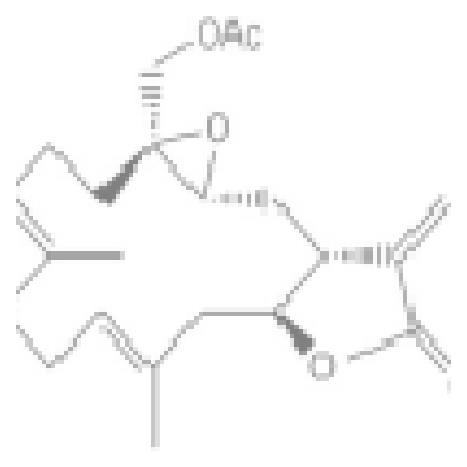

In [0]:
t = tensor_from_image("images/thumb70/PMC4002701_aps2012100f1.png")
imshow(t)

In [0]:
!ls -al


total 16
drwxr-xr-x 1 root root 4096 Aug 27 16:17 .
drwxr-xr-x 1 root root 4096 Oct 18 14:31 ..
drwxr-xr-x 1 root root 4096 Oct 11 15:15 .config
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data
